# Software Vulnerability Detection using Deep Learning (Experiment Replication)

* This is from Russell et. al work (Automated Vulnerability Detection in Source Code Using Deep Representation Learning) https://arxiv.org/abs/1807.04320
* Datasets downloaded from https://osf.io/d45bw/
* Datasets distribution: Training (80%), Validation (10%), Testing (10%)
* The dataset consists of the source code of 1.27 million functions mined from open source software, labeled by static analysis for potential vulnerabilities.
* Each function's raw source code, starting from the function name, is stored as a variable-length UTF-8 string. Five binary 'vulnerability' labels are provided for each function, corresponding to the four most common CWEs in our data plus all others: 
 * CWE-120 (3.7% of functions)
 * CWE-119 (1.9% of functions)
 * CWE-469 (0.95% of functions)
 * CWE-476 (0.21% of functions)
 * CWE-other (2.7% of functions)
* Functions may have more than one detected CWE each.
* Python 3.6 and Tensorflow 2.0.0

## Pre-processing

Converting the HDF5 files for training/validation/testing datasets to python pickle for ease of future usage

In [9]:
import h5py
import pandas as pd

In [15]:
# 3 datasets available

data = h5py.File("VDISC_train.hdf5",'r')
#data = h5py.File("VDISC_validate.hdf5",'r')
#data = h5py.File("VDISC_test.hdf5",'r')

In [30]:
# List all groups
data.visit(print)

CWE-119
CWE-120
CWE-469
CWE-476
CWE-other
functionSource


Create a new dataframe from the HDF5 file

In [16]:
mydf = pd.DataFrame(list(data['functionSource']))

In [17]:
mydf['CWE-119']=list(data['CWE-119']); mydf['CWE-120']=list(data['CWE-120']); mydf['CWE-469']=list(data['CWE-469']); mydf['CWE-476']=list(data['CWE-476']); mydf['CWE-other']=list(data['CWE-other']) 

In [18]:
mydf.rename(columns={0:'functionSource'},inplace=True)

In [71]:
mydf.iloc[0:5,0:]

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"clear_area(int startx, int starty, int xsize, ...",False,False,False,False,False
1,ReconstructDuList(Statement* head)\n{\n Sta...,False,False,False,False,False
2,free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,mlx4_register_device(struct mlx4_dev *dev)\n{\...,False,False,False,False,False
4,"Parse_Env_Var(void)\n{\n char *p = getenv(""LI...",True,True,False,False,True


In [19]:
mydf.to_pickle("VDISC_train.pickle")
#mydf.to_pickle("VDISC_validate.pickle")
#mydf.to_pickle("VDISC_test.pickle")

## Exploratory Data Analysis

### Importing processed datasets

In [66]:
train=pd.read_pickle("VDISC_train.pickle")
validate=pd.read_pickle("VDISC_validate.pickle")
test=pd.read_pickle("VDISC_test.pickle")

In [4]:
### CONTINUE LATER

## Learning Phase

### Importing libraries

In [118]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

print("Tensorlfow version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensorlfow version:  2.0.0
Eager mode:  True
GPU is available


### Setting static and global variables

In [2]:
# Generate random seed
myrand=np.random.randint(1, 99999 + 1)
np.random.seed(myrand)
tf.random.set_seed(myrand)
print("Random seed is:",myrand)

Random seed is: 71926


In [3]:
# Set the global value
WORDS_SIZE=10000
INPUT_SIZE=500
NUM_CLASSES=2
MODEL_NUM=0
EPOCHS=10

### Importing processed datasets

In [4]:
train=pd.read_pickle("VDISC_train.pickle")
validate=pd.read_pickle("VDISC_validate.pickle")
test=pd.read_pickle("VDISC_test.pickle")

# Create source code sdata for tokenization
x_all = train['functionSource']
x_all = x_all.append(validate['functionSource'])
x_all = x_all.append(test['functionSource'])

In [5]:
# Overview of the datasets
train.head()

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"clear_area(int startx, int starty, int xsize, ...",False,False,False,False,False
1,ReconstructDuList(Statement* head)\n{\n Sta...,False,False,False,False,False
2,free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,mlx4_register_device(struct mlx4_dev *dev)\n{\...,False,False,False,False,False
4,"Parse_Env_Var(void)\n{\n char *p = getenv(""LI...",True,True,False,False,True


### Tokenizing the source codes

In [6]:
# Tokenizer with word-level
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=False)
tokenizer.fit_on_texts(list(x_all))
del(x_all)
print('Number of tokens: ',len(tokenizer.word_counts))

Number of tokens:  1207818


In [7]:
# Reducing to top N words
tokenizer.num_words = WORDS_SIZE

In [8]:
# Top 10 words
sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]

[('if', 3908040),
 ('0', 2633095),
 ('return', 2182544),
 ('i', 1720280),
 ('1', 1483872),
 ('int', 1271988),
 ('null', 1222633),
 ('the', 990541),
 ('t', 917046),
 ('n', 892342)]

### Create sequence files from the tokens

In [9]:
## Tokkenizing train data and create matrix
list_tokenized_train = tokenizer.texts_to_sequences(train['functionSource'])
tf.keras.preprocessing.sequence
x_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, 
                                  maxlen=INPUT_SIZE,
                                  padding='post')
x_train = x_train.astype(np.int64)

In [10]:
## Tokkenizing test data and create matrix
list_tokenized_test = tokenizer.texts_to_sequences(test['functionSource'])
x_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_test = x_test.astype(np.int64)

In [11]:
## Tokkenizing validate data and create matrix
list_tokenized_validate = tokenizer.texts_to_sequences(validate['functionSource'])
x_validate = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_validate, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_validate = x_validate.astype(np.int64)

In [13]:
# Example data
validate.iloc[0,1:6]

CWE-119      False
CWE-120      False
CWE-469      False
CWE-476      False
CWE-other    False
Name: 0, dtype: object

### One-Hot-Enconding (OHE) on the datasets

In [61]:
y_train=[]
y_test=[]
y_validate=[]

for col in range(1,6):
    y_train.append(tf.keras.utils.to_categorical(train.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_test.append(tf.keras.utils.to_categorical(test.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_validate.append(tf.keras.utils.to_categorical(validate.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))

In [62]:
# Example data
y_test[0][1:10]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int64)

### Model Definition (CNN with Gaussian Noise and 5 Output Splits)

In [96]:
# Must use non-sequential model building to create branches in the output layer

inp_layer = tf.keras.layers.Input(shape=(INPUT_SIZE,))
mid_layers = tf.keras.layers.Embedding(input_dim = WORDS_SIZE,
                                    output_dim = 13,
                                    input_length = INPUT_SIZE)(inp_layer)
mid_layers = tf.keras.layers.GaussianNoise(stddev=np.sqrt(0.01))(mid_layers)
mid_layers = tf.keras.layers.Convolution1D(filters=512, kernel_size=(9), padding='same', activation='relu')(mid_layers)
mid_layers = tf.keras.layers.MaxPool1D(pool_size=50)(mid_layers)
mid_layers = tf.keras.layers.Flatten()(mid_layers)
mid_layers = tf.keras.layers.Dense(64, activation='relu')(mid_layers)
mid_layers = tf.keras.layers.Dense(16, activation='relu')(mid_layers)
output1 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output2 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output3 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output4 =tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output5 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
model = tf.keras.Model(inp_layer,[output1,output2,output3,output4,output5])

# Define custom optimizers
adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.0, amsgrad=False)

## Compile model with metrics
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print("CNN model built: ")
model.summary()

CNN model built: 
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 500, 13)      130000      input_29[0][0]                   
__________________________________________________________________________________________________
gaussian_noise_28 (GaussianNois (None, 500, 13)      0           embedding_41[0][0]               
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 500, 512)     60416       gaussian_noise_28[0][0]          
_________________________________________________________________________

### Tensorboard Callbacks

In [109]:
## Create TensorBoard callbacks

callbackdir= 'D:\\temp\\cb'

tbCallback = tf.keras.callbacks.TensorBoard(log_dir=callbackdir, 
                         histogram_freq=1,
                         embeddings_freq=1,
                         write_graph=True, 
                         write_images=True)

tbCallback.set_model(model)
mld = 'D:\\temp\\model\\saved-model-epoch-{epoch:02d}.hdf5'

## Create best model callback
mcp = tf.keras.callbacks.ModelCheckpoint(filepath=mld, 
                                         monitor="accuracy",
                                         save_best_only=False, 
                                         mode='auto', 
                                         save_freq='epoch', 
                                         verbose=1)

### Model Training

In [110]:
history = model.fit(x = x_train,
          y = y_train,
          validation_data = (x_validate, y_validate),
          epochs = EPOCHS,
          batch_size = 128,
          verbose =2,
          callbacks=[mcp,tbCallback])

Train on 1019471 samples, validate on 127476 samples
Epoch 1/10

Epoch 00001: saving model to D:\temp\model\saved-model-epoch-1.hdf5
1019471/1019471 - 530s - loss: 0.4382 - dense_145_loss: 0.0917 - dense_146_loss: 0.1557 - dense_147_loss: 0.0143 - dense_148_loss: 0.0530 - dense_149_loss: 0.1235 - dense_145_accuracy: 0.9811 - dense_146_accuracy: 0.9627 - dense_147_accuracy: 0.9979 - dense_148_accuracy: 0.9905 - dense_149_accuracy: 0.9726 - val_loss: 0.6754 - val_dense_145_loss: 0.1467 - val_dense_146_loss: 0.2154 - val_dense_147_loss: 0.0402 - val_dense_148_loss: 0.0971 - val_dense_149_loss: 0.1760 - val_dense_145_accuracy: 0.9810 - val_dense_146_accuracy: 0.9627 - val_dense_147_accuracy: 0.9980 - val_dense_148_accuracy: 0.9905 - val_dense_149_accuracy: 0.9719
Epoch 2/10

Epoch 00002: saving model to D:\temp\model\saved-model-epoch-1.hdf5
1019471/1019471 - 540s - loss: 0.4365 - dense_145_loss: 0.0913 - dense_146_loss: 0.1549 - dense_147_loss: 0.0143 - dense_148_loss: 0.0530 - dense_149_

### Model Evaluation using Testing Set

In [116]:
model = tf.keras.models.load_model("D:/temp/model/saved-model-epoch-1.hdf5")
results = model.evaluate(x_test, y_test, batch_size=128)
for num in range(0,len(model.metrics_names)):
    print(model.metrics_names[num]+': '+str(results[num]))

loss: 0.6030870046893764
dense_145_loss: 0.12782237
dense_146_loss: 0.19809516
dense_147_loss: 0.031646125
dense_148_loss: 0.08403076
dense_149_loss: 0.16150272
dense_145_accuracy: 0.9807564
dense_146_accuracy: 0.96161485
dense_147_accuracy: 0.99781823
dense_148_accuracy: 0.99064505
dense_149_accuracy: 0.97261006


### Check The Evaluation Metrics

In [ ]:
print('\nConfusion Matrix')
predicted = model.outputs
confusion = sklearn.metrics.confusion_matrix(y_true=old_y_test, y_pred=predicted)
print(confusion)

## Performance measure
print('\nWeighted Accuracy: '+ str(sklearn.metrics.accuracy_score(y_true=old_y_test, y_pred=predicted)))
print('Weighted precision: '+ str(sklearn.metrics.precision_score(y_true=old_y_test, y_pred=predicted, average='weighted')))
print('Weighted recall: '+ str(sklearn.metrics.recall_score(y_true=old_y_test, y_pred=predicted, average='weighted')))
print('Weighted f-measure: '+ str(sklearn.metrics.f1_score(y_true=old_y_test, y_pred=predicted, average='weighted')))

In [152]:
#predicted=model.predict(x_test)
np.shape(predicted[0])

(127419, 2)

### Plot The Model's Training History

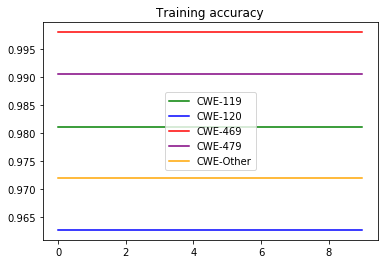

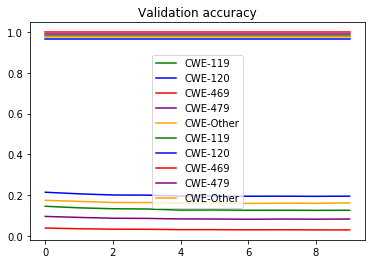

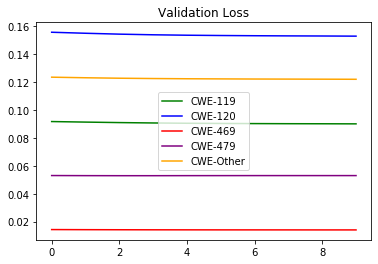

In [159]:
epochs_range = range(len(history.history['val_dense_145_accuracy']))

plt.plot(epochs_range, history.history['val_dense_145_accuracy'], 'b', label='CWE-119', color='green')
plt.plot(epochs_range, history.history['val_dense_146_accuracy'], 'b', label='CWE-120', color='blue')
plt.plot(epochs_range, history.history['val_dense_147_accuracy'], 'b', label='CWE-469', color='red')
plt.plot(epochs_range, history.history['val_dense_148_accuracy'], 'b', label='CWE-479', color='purple')
plt.plot(epochs_range, history.history['val_dense_149_accuracy'], 'b', label='CWE-Other', color='orange')
plt.title('Training accuracy')
plt.legend()


plt.figure()
plt.plot(epochs_range, history.history['val_dense_145_loss'], 'b', label='CWE-119', color='green')
plt.plot(epochs_range, history.history['val_dense_146_loss'], 'b', label='CWE-120', color='blue')
plt.plot(epochs_range, history.history['val_dense_147_loss'], 'b', label='CWE-469', color='red')
plt.plot(epochs_range, history.history['val_dense_148_loss'], 'b', label='CWE-479', color='purple')
plt.plot(epochs_range, history.history['val_dense_149_loss'], 'b', label='CWE-Other', color='orange')
plt.title('Training Loss')
plt.legend()

plt.plot(epochs_range, history.history['dense_145_accuracy'], 'b', label='CWE-119', color='green')
plt.plot(epochs_range, history.history['dense_146_accuracy'], 'b', label='CWE-120', color='blue')
plt.plot(epochs_range, history.history['dense_147_accuracy'], 'b', label='CWE-469', color='red')
plt.plot(epochs_range, history.history['dense_148_accuracy'], 'b', label='CWE-479', color='purple')
plt.plot(epochs_range, history.history['dense_149_accuracy'], 'b', label='CWE-Other', color='orange')
plt.title('Validation accuracy')
plt.legend()


plt.figure()
plt.plot(epochs_range, history.history['dense_145_loss'], 'b', label='CWE-119', color='green')
plt.plot(epochs_range, history.history['dense_146_loss'], 'b', label='CWE-120', color='blue')
plt.plot(epochs_range, history.history['dense_147_loss'], 'b', label='CWE-469', color='red')
plt.plot(epochs_range, history.history['dense_148_loss'], 'b', label='CWE-479', color='purple')
plt.plot(epochs_range, history.history['dense_149_loss'], 'b', label='CWE-Other', color='orange')
plt.title('Validation Loss')
plt.legend()



plt.show()

